In [1]:
import numpy as np
import random
import json
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import glob

from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic=True 

In [3]:
meta = json.load(open('/content/drive/MyDrive/TUM/assignments i2dl/assignment2/meta.json', 'r'))
tokens = meta['tokens']
num_token = len(tokens)
num_user = meta['num_user']
print('In dataset, there are {} number of tokens (words) and these tweets are from {} users'.format(num_token, num_user))

In dataset, there are 13369 number of tokens (words) and these tweets are from 8 users


In [4]:
train_data = json.load(open('/content/drive/MyDrive/TUM/assignments i2dl/assignment2/train.json', 'r'))
valid_data = json.load(open('/content/drive/MyDrive/TUM/assignments i2dl/assignment2/valid.json', 'r'))
s_idx = 0
print('{} tweets in train dataset, {} tweets in valid dataset.'.format(len(train_data), len(valid_data)))
print('Each json file is a list of dictionary, and each dictionary has information of tweets')
print('[TWEET INFO]: user id, sentence, processed token id.')
print()

print('Sample train data: ', train_data[s_idx])
print()
print('Note that: tokens.index(word) = token_id')
print()
print('Example:')
print(train_data[0]['token_id'])
print([tokens.index(w) for w in train_data[s_idx]['sentence'].split()])

6400 tweets in train dataset, 356 tweets in valid dataset.
Each json file is a list of dictionary, and each dictionary has information of tweets
[TWEET INFO]: user id, sentence, processed token id.

Sample train data:  {'user_id': 0, 'sentence': 'i recently met lakeisha crum the first in her family to go to college loved her story', 'token_id': [5721, 9659, 7459, 6629, 2686, 11853, 4447, 5870, 5460, 4236, 12017, 4981, 12017, 2197, 7047, 5460, 11310]}

Note that: tokens.index(word) = token_id

Example:
[5721, 9659, 7459, 6629, 2686, 11853, 4447, 5870, 5460, 4236, 12017, 4981, 12017, 2197, 7047, 5460, 11310]
[5721, 9659, 7459, 6629, 2686, 11853, 4447, 5870, 5460, 4236, 12017, 4981, 12017, 2197, 7047, 5460, 11310]


In [5]:
class tweetDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        sample['token_id'] = torch.Tensor(sample['token_id'])
        return sample

In [6]:
train_dataset = tweetDataset(train_data)
valid_dataset = tweetDataset(valid_data)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

In [7]:
sample = next(iter(train_dataloader))

print('Sample from train dataloader: ')
print('USER ID: ', sample['user_id'])
print('TOKEN ID: ', sample['token_id'])
print('TOKEN ID shape should be BATCH by LENGTH: ', sample['token_id'].shape)

Sample from train dataloader: 
USER ID:  tensor([7])
TOKEN ID:  tensor([[ 3241., 13106.,  9990.,  8273., 12974.,   781.,  6760., 12919.,  5360.,
          9394., 12017., 11108.,  8324.,  7987.,  8273., 12828., 11851.,  6847.]])
TOKEN ID shape should be BATCH by LENGTH:  torch.Size([1, 18])


In [8]:
class Model(nn.Module):
    def __init__(self, num_token, num_user, embed_dim, rnn_dim, num_layers):
        super(Model, self).__init__()
        self.num_token = num_token
        self.num_user = num_user
        self.embed_dim = embed_dim
        self.rnn_dim = rnn_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(num_token, embed_dim)
        self.rnn = nn.RNN(embed_dim, rnn_dim, num_layers=num_layers, batch_first=True)
        self.out_linear = nn.Linear(rnn_dim, num_user)
        
    def forward(self, token_id):
        embed = self.embedding(token_id)
        out, _ = self.rnn(embed)
        return self.out_linear(out[:, -1])

In [9]:
device = 'cuda'
#device = 'cpu'

model = Model(num_token, num_user, embed_dim=512, rnn_dim=1024, num_layers=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-7)

In [10]:
num_param = sum(p.numel() for p in model.parameters())
print('Number of parameters: {}'.format(num_param))
print('[NOTE] Number of parameters SHOULD NOT exceed 20,000,000 (20 million).')
pred = model(sample['token_id'].long().to(device))
print('Prediction shape would be BATCH X NUM_USER(OUTPUT) : ', pred.shape)

Number of parameters: 8428040
[NOTE] Number of parameters SHOULD NOT exceed 20,000,000 (20 million).
Prediction shape would be BATCH X NUM_USER(OUTPUT) :  torch.Size([1, 8])


In [11]:
criteria = nn.CrossEntropyLoss()
avg_loss = 0.0
best_valid_accu = 0.0
best_epoch = -1
best_model = None
num_epoch = 100
x,y = [],[]

for epoch in tqdm(range(num_epoch)):
    # start training
    for sample in train_dataloader:
        model.train()
        optimizer.zero_grad()

        pred = model(sample['token_id'].long().to(device))

        loss = criteria(pred, sample['user_id'].long().to(device))

        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_dataloader)

    # start validation
    correct_cnt = 0.0
    data_cnt = 0.0
    for sample in valid_dataloader:
        model.eval()

        with torch.no_grad():
            pred = model(sample['token_id'].long().to(device))

        pred_user_id = torch.argmax(pred, dim=-1)

        accu = pred_user_id.detach().cpu() == sample['user_id']

        correct_cnt += torch.sum(accu)
        data_cnt += sample['token_id'].shape[0]

    # calculate best valid accuracy, and save the best model. 
    curr_valid_accu = (correct_cnt / data_cnt).item()
    print('[EPOCH {}] VALID ACCURACY: {}'.format(epoch, curr_valid_accu))
    x.append(epoch)
    y.append(curr_valid_accu)

    best_valid_accu = max(best_valid_accu, curr_valid_accu)
    if best_valid_accu == curr_valid_accu:
        best_epoch = epoch
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), 'best_baseline.pth')
        print('[EPOCH {}] BEST VALID ACCURACY UPDATED: {}'.format(epoch, best_valid_accu))

print('FINISHED TRAINING : BEST MODEL AT EPOCH {} WITH ACCURACY {}'.format(best_epoch, best_valid_accu))

  0%|          | 0/100 [00:00<?, ?it/s]

[EPOCH 0] VALID ACCURACY: 0.30337077379226685
[EPOCH 0] BEST VALID ACCURACY UPDATED: 0.30337077379226685
[EPOCH 1] VALID ACCURACY: 0.483146071434021
[EPOCH 1] BEST VALID ACCURACY UPDATED: 0.483146071434021
[EPOCH 2] VALID ACCURACY: 0.5421348214149475
[EPOCH 2] BEST VALID ACCURACY UPDATED: 0.5421348214149475
[EPOCH 3] VALID ACCURACY: 0.584269642829895
[EPOCH 3] BEST VALID ACCURACY UPDATED: 0.584269642829895
[EPOCH 4] VALID ACCURACY: 0.5786516666412354
[EPOCH 5] VALID ACCURACY: 0.5814606547355652
[EPOCH 6] VALID ACCURACY: 0.5955055952072144
[EPOCH 6] BEST VALID ACCURACY UPDATED: 0.5955055952072144
[EPOCH 7] VALID ACCURACY: 0.601123571395874
[EPOCH 7] BEST VALID ACCURACY UPDATED: 0.601123571395874
[EPOCH 8] VALID ACCURACY: 0.6235954761505127
[EPOCH 8] BEST VALID ACCURACY UPDATED: 0.6235954761505127
[EPOCH 9] VALID ACCURACY: 0.5898876190185547
[EPOCH 10] VALID ACCURACY: 0.6151685118675232
[EPOCH 11] VALID ACCURACY: 0.617977499961853
[EPOCH 12] VALID ACCURACY: 0.5870786309242249
[EPOCH 13] 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[0.30337077379226685, 0.483146071434021, 0.5421348214149475, 0.584269642829895, 0.5786516666412354, 0.5814606547355652, 0.5955055952072144, 0.601123571395874, 0.6235954761505127, 0.5898876190185547, 0.6151685118675232, 0.617977499961853, 0.5870786309242249, 0.6039325594902039, 0.6123595237731934, 0.6207864880561829, 0.6123595237731934, 0.6207864880561829, 0.6095505356788635, 0.601123571395874, 0.5646067261695862, 0.6123595237731934, 0.617977499961853, 0.6264045238494873, 0.601123571395874, 0.6264045238494873, 0.5870786309242249, 0.6123595237731934, 0.617977499961853, 0.6123595237731934, 0.6376404762268

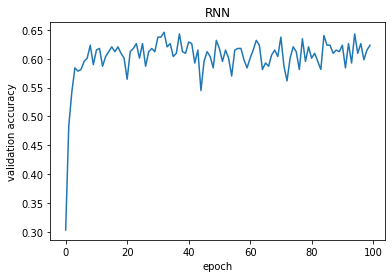

In [12]:
print(x)
print(y)

import matplotlib.pyplot as plt
plt.plot(x, y)
 
# naming the x axis
plt.xlabel('epoch')
# naming the y axis
plt.ylabel('validation accuracy')
 
# giving a title to my graph
plt.title('RNN')
 
# function to show the plot
plt.show()